In [1]:
import dolfin as dl
import scipy.io as sp
import numpy as np
import ufl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mat4py as m4p
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "..") + "/applications/ad_diff/" )
from model_ad_diff import TimeDependentAD, SpaceTimePointwiseStateObservation

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

In [2]:
def v_boundary(x,on_boundary):
    return on_boundary

def q_boundary(x,on_boundary):
    return x[0] < dl.DOLFIN_EPS and x[1] < dl.DOLFIN_EPS
        
def computeVelocityField(mesh):
    Xh = dl.VectorFunctionSpace(mesh,'Lagrange', 2)
    Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)
    mixed_element = ufl.MixedElement([Xh.ufl_element(), Wh.ufl_element()])
    XW = dl.FunctionSpace(mesh, mixed_element)

    Re = dl.Constant(1e2)
    
    g = dl.Expression(('0.0','(x[0] < 1e-14) - (x[0] > 1 - 1e-14)'), degree=1)
    bc1 = dl.DirichletBC(XW.sub(0), g, v_boundary)
    bc2 = dl.DirichletBC(XW.sub(1), dl.Constant(0), q_boundary, 'pointwise')
    bcs = [bc1, bc2]
    
    vq = dl.Function(XW)
    (v,q) = ufl.split(vq)
    (v_test, q_test) = dl.TestFunctions (XW)
    
    def strain(v):
        return ufl.sym(ufl.grad(v))
    
    F = ( (2./Re)*ufl.inner(strain(v),strain(v_test))+ ufl.inner (ufl.nabla_grad(v)*v, v_test)
           - (q * ufl.div(v_test)) + ( ufl.div(v) * q_test) ) * ufl.dx
           
    dl.solve(F == 0, vq, bcs, solver_parameters={"newton_solver":
                                         {"relative_tolerance":1e-4, "maximum_iterations":100}})
    
    plt.figure(figsize=(15,5))
    vh = dl.project(v,Xh)
    qh = dl.project(q,Wh)
    nb.plot(nb.coarsen_v(vh), subplot_loc=121,mytitle="Velocity")
    nb.plot(qh, subplot_loc=122,mytitle="Pressure")
    plt.show()
        
    return v

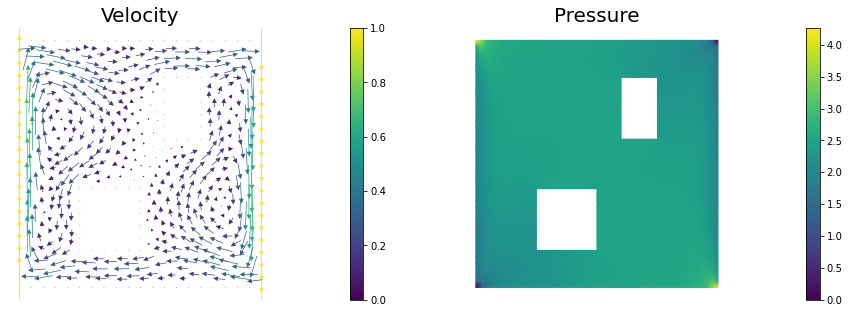

Number of dofs: 2023


In [3]:
mesh = dl.refine( dl.Mesh("ad_20.xml") )
wind_velocity = computeVelocityField(mesh)
Vh = dl.FunctionSpace(mesh, "Lagrange", 1)
print( "Number of dofs: {0}".format( Vh.dim() ) )

In [ ]:
# STORE MESHPOINTS AS MATLAB FILE

r=mesh.coordinates()
bx=r[:,0]
by=r[:,1]
bx=list(bx)
by=list(by)
data_x = {'x': bx}
data_y = {'x': by}
m4p.savemat('datafile_new_x.mat', data_x)
m4p.savemat('datafile_new_y.mat', data_y)

Number of observation points: 80


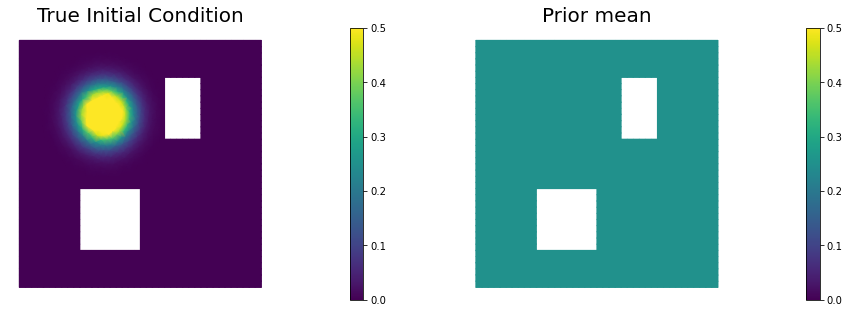

In [11]:
ic_expr = dl.Expression(
    'std::min(0.5,std::exp(-100*(std::pow(x[0]-0.35,2) +  std::pow(x[1]-0.7,2))))',
    element=Vh.ufl_element())
true_initial_condition = dl.interpolate(ic_expr, Vh).vector()
gamma = 1.
delta = 8.
prior = BiLaplacianPrior(Vh, gamma, delta, robin_bc=True)

prior.mean = dl.interpolate(dl.Constant(0.25), Vh).vector()
    
t_init         = 0.
t_final        = 4.
t_1            = 1.
dt             = .1
observation_dt = .2
    
simulation_times = np.arange(t_init, t_final+.5*dt, dt)
observation_times = np.arange(t_1, t_final+.5*dt, observation_dt)
    
targets = np.loadtxt('targets.txt')
print ("Number of observation points: {0}".format(targets.shape[0]) )
misfit = SpaceTimePointwiseStateObservation(Vh, observation_times, targets)

problem = TimeDependentAD(mesh, [Vh,Vh,Vh], prior, misfit, simulation_times, wind_velocity, True)


objs = [dl.Function(Vh,true_initial_condition),
        dl.Function(Vh,prior.mean)]
mytitles = ["True Initial Condition", "Prior mean"]
nb.multi1_plot(objs, mytitles)
plt.show()

In [ ]:
# FORM THE LINEAR OPERATOR THAT MAPS INITIAL DATA TO THE SOLUTION AT THE FINAL TIME

length=len(true_initial_condition.get_local())
A=np.zeros((length,length))

for i in range(0,length):
    new=0*true_initial_condition
    new[i]=1
    utrue = problem.generate_vector(STATE)
    x = [utrue, new, None]
    problem.solveFwd(x[STATE], x)
    
    
    val=np.array(utrue.data)
    final_solution=val[40]
    A[:,i]=final_solution

In [ ]:
# STORE THE GENERATED LINEAR OPERATOR AS MAT FILE
savedict = {
    'A' : A
}
sp.savemat('TRIAL.mat', savedict)

In [8]:
# STORING TRUE INITIAL CONDITION  as .mat file

a=true_initial_condition
b=a.get_local()
b=list(b)
data = {'x': b}
m4p.savemat('initial_condition.mat', data)


In [9]:
# Storing observation data at final time

utrue = problem.generate_vector(STATE)
x = [utrue, true_initial_condition, None]
problem.solveFwd(x[STATE], x)

val=np.array(utrue.data)
final_solution=val[40]
bb=list(final_solution)
data_final_solution = {'x': bb}
m4p.savemat('observation.mat', data_final_solution)